In [1]:
from IPython.display import HTML
HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')

# Prediction Models by Comorbidities
In this notebook we build different models to predict the 30-day readmission rate by the 29 comorbidity categories. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import os

In [2]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
%matplotlib inline

In [4]:
path = '/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/NRD/'

In [3]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/'

In [5]:
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

## Data reading and splitting
We first read the ami index cohort, select only the first admission of each patient, and do a train-test splitting. 

In [6]:
admissions = pd.read_csv(path+'cohorts/ami/comorbidities.csv')

In [8]:
admissions.columns

Index(['CM_AIDS', 'CM_ALCOHOL', 'CM_ANEMDEF', 'CM_ARTH', 'CM_BLDLOSS',
       'CM_CHF', 'CM_CHRNLUNG', 'CM_COAG', 'CM_DEPRESS', 'CM_DM', 'CM_DMCX',
       'CM_DRUG', 'CM_HTN_C', 'CM_HYPOTHY', 'CM_LIVER', 'CM_LYMPH', 'CM_LYTES',
       'CM_METS', 'CM_NEURO', 'CM_OBESE', 'CM_PARA', 'CM_PERIVASC', 'CM_PSYCH',
       'CM_PULMCIRC', 'CM_RENLFAIL', 'CM_TUMOR', 'CM_ULCER', 'CM_VALVE',
       'CM_WGHTLOSS', 'KEY_NRD', 'AGE', 'FEMALE', 'HOSP_NRD', 'NRD_VisitLink',
       'NRD_DaysToEvent', 'readm30'],
      dtype='object')

In [7]:
comorb = ['CM_AIDS', 'CM_ALCOHOL', 'CM_ANEMDEF', 'CM_ARTH', 'CM_BLDLOSS',
       'CM_CHF', 'CM_CHRNLUNG', 'CM_COAG', 'CM_DEPRESS', 'CM_DM', 'CM_DMCX',
       'CM_DRUG', 'CM_HTN_C', 'CM_HYPOTHY', 'CM_LIVER', 'CM_LYMPH', 'CM_LYTES',
       'CM_METS', 'CM_NEURO', 'CM_OBESE', 'CM_PARA', 'CM_PERIVASC', 'CM_PSYCH',
       'CM_PULMCIRC', 'CM_RENLFAIL', 'CM_TUMOR', 'CM_ULCER', 'CM_VALVE',
       'CM_WGHTLOSS']

In [8]:
admissions = admissions.sort_values(['NRD_VisitLink', 'NRD_DaysToEvent'])

Pick only the first admission of each patient, i.e., one patient only contribute one sample:

In [9]:
patients_first = admissions.drop_duplicates(subset=['NRD_VisitLink'])

In [10]:
patients_first['readm30'].value_counts()

False    170265
True      25430
Name: readm30, dtype: int64

In [10]:
patients_first.to_csv(path+'cohorts/ami/patients_first.csv', index=False)

In [11]:
train_df, test_df = train_test_split(patients_first, test_size=0.1, random_state=24, stratify = patients_first['HOSP_NRD'])

In [12]:
train_df.to_csv(path+'cohorts/ami/comorb_train.csv', index=False)
test_df.to_csv(path+'cohorts/ami/comorb_test.csv', index=False)

In [5]:
train_df = pd.read_csv(path+'cohorts/ami/comorb_train.csv')
test_df = pd.read_csv(path+'cohorts/ami/comorb_test.csv')

## Mixed Effects Logistic Regression
This part is done by the R package lme4, in a separate notebook "Mixed_effect_logistic.ipynb". Here we directly read the result: prediction scores and the true outcomes for the test set.

In [13]:
pred_test = pd.read_csv(path+'cohorts/ami/prediction_MELR.csv')

### Result visualization

In [15]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [16]:
from DL_utils import plot_roc

{0: 0.6680398651215139}

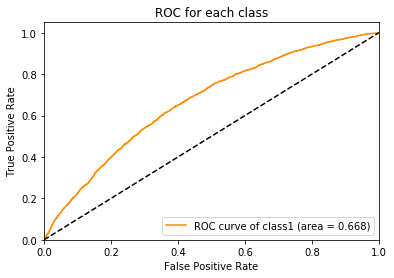

In [17]:
plot_roc(pred_test['y_pred'].values, pred_test['y_true'].values)

## Fully Connected Neural Nets

### Prepare the training data

In [5]:
df = pd.read_csv(path+'cohorts/ami/comorb_train.csv')

In [11]:
comorb = ['CM_AIDS', 'CM_ALCOHOL', 'CM_ANEMDEF', 'CM_ARTH', 'CM_BLDLOSS',
       'CM_CHF', 'CM_CHRNLUNG', 'CM_COAG', 'CM_DEPRESS', 'CM_DM', 'CM_DMCX',
       'CM_DRUG', 'CM_HTN_C', 'CM_HYPOTHY', 'CM_LIVER', 'CM_LYMPH', 'CM_LYTES',
       'CM_METS', 'CM_NEURO', 'CM_OBESE', 'CM_PARA', 'CM_PERIVASC', 'CM_PSYCH',
       'CM_PULMCIRC', 'CM_RENLFAIL', 'CM_TUMOR', 'CM_ULCER', 'CM_VALVE',
       'CM_WGHTLOSS']

In [6]:
trn_df, val_df = train_test_split(df, test_size=0.11, random_state=24, stratify = df['HOSP_NRD'])

In [7]:
N_trn = len(trn_df)
N_val = len(val_df)

In [12]:
X_trn = trn_df[['AGE', 'FEMALE']+comorb].values
X_val = val_df[['AGE', 'FEMALE']+comorb].values

mean_age = trn_df['AGE'].mean()
sigma_age = trn_df['AGE'].std()
X_trn[:, 0] = (X_trn[:, 0] - mean_age)/sigma_age
X_val[:, 0] = (X_val[:, 0] - mean_age)/sigma_age

In [24]:
mean_age, sigma_age

(66.17134972231185, 13.808092896091805)

In [13]:
hosp_series = pd.concat([trn_df, val_df])['HOSP_NRD']
hosp_series = hosp_series.astype(int).astype('category')

old_cat = hosp_series.cat.categories
n_cat = len(old_cat)

hosp_series = hosp_series.cat.rename_categories(range(n_cat))
hosp_array = hosp_series.astype(int).values

hosp_trn = hosp_array[:N_trn]
hosp_val = hosp_array[N_trn:]

In [14]:
y_trn = trn_df['readm30'].values.astype(int)
y_val = val_df['readm30'].values.astype(int)

In [27]:
X_trn.shape, hosp_trn.shape, y_trn.shape, X_val.shape, hosp_val.shape, y_val.shape

((145667, 31), (145667,), (145667,), (18004, 31), (36190,), (18004,))

In [33]:
X_trn.dtype, hosp_trn.dtype, y_trn.dtype

(dtype('float64'), dtype('int64'), dtype('int64'))

### Model building

In [22]:
from keras.layers import Input, Embedding, concatenate, Reshape, BatchNormalization
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from keras.utils import to_categorical

In [75]:
from importlib import reload
import keras_addon
reload(keras_addon)

<module 'keras_addon' from '/home/wsliu/Codes/DLproj/keras_addon.py'>

In [18]:
from keras_addon import AUCCheckPoint

In [19]:
Y_trn = to_categorical(y_trn)
Y_val = to_categorical(y_val)

In [20]:
input_X = Input(shape=(31,))

embed_dim = 2
input_hosp = Input(shape=(1,))
embed_out = Embedding(n_cat, embed_dim, input_length=1)(input_hosp)
embed_out = Reshape((embed_dim,))(embed_out)

merged_X = concatenate([input_X, embed_out], axis=1)

x = Dense(64, activation='relu')(merged_X)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
#x = Dense(16, activation='relu')(x)

prediction = Dense(2, activation='softmax', name='readm')(x)
model = Model(inputs=[input_X, input_hosp], outputs=prediction)

In [23]:
adam = Adam(0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
#checkpointer = ModelCheckpoint(filepath=model_path+'ami_comorb1.h5', verbose=0, save_best_only=True, save_weights_only=True)
auc_checkpoint = AUCCheckPoint(model_path+'ami_comorb_auc1.h5', validation_y=y_val, validation_x=[X_val, hosp_val])
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=1.e-8)
earlystop = EarlyStopping(monitor='val_loss', patience=10)

In [25]:
class_weight = {0:(len(y_trn)/sum(Y_trn[:,0])), 1:(len(y_trn)/sum(Y_trn[:,1]))}

In [27]:
hist = model.fit([X_trn, hosp_trn], Y_trn, batch_size=256, epochs=50, callbacks=[auc_checkpoint, reduce_lr, earlystop],
                 validation_data=[[X_val, hosp_val], Y_val], class_weight = class_weight, verbose=2)

Train on 145667 samples, validate on 18004 samples
Epoch 1/50
 - 5s - loss: 1.3225 - acc: 0.5927 - val_loss: 0.6609 - val_acc: 0.5754
AUC: 0.6715

Epoch 2/50
 - 2s - loss: 1.3039 - acc: 0.5886 - val_loss: 0.6437 - val_acc: 0.6004
AUC: 0.6744

Epoch 3/50
 - 2s - loss: 1.2903 - acc: 0.5855 - val_loss: 0.6305 - val_acc: 0.6070
AUC: 0.6741

Epoch 4/50
 - 2s - loss: 1.2874 - acc: 0.5793 - val_loss: 0.6696 - val_acc: 0.5653
AUC: 0.6724

Epoch 5/50
 - 2s - loss: 1.2829 - acc: 0.5826 - val_loss: 0.6560 - val_acc: 0.5625
AUC: 0.6737

Epoch 6/50
 - 2s - loss: 1.2806 - acc: 0.5844 - val_loss: 0.6542 - val_acc: 0.5745
AUC: 0.6731

Epoch 7/50
 - 2s - loss: 1.2763 - acc: 0.5886 - val_loss: 0.6307 - val_acc: 0.5972
AUC: 0.6709

Epoch 8/50
 - 2s - loss: 1.2731 - acc: 0.5869 - val_loss: 0.6182 - val_acc: 0.6099
AUC: 0.6725

Epoch 9/50
 - 2s - loss: 1.2694 - acc: 0.5890 - val_loss: 0.6518 - val_acc: 0.5742
AUC: 0.6712

Epoch 10/50
 - 2s - loss: 1.2679 - acc: 0.5876 - val_loss: 0.6640 - val_acc: 0.5630
A

### Model Testing

In [41]:
from DL_utils import plot_roc

In [29]:
tst_df = pd.read_csv(path+'cohorts/ami/comorb_test.csv')

In [30]:
X_tst = tst_df[['AGE', 'FEMALE']+comorb].values
X_tst[:, 0] = (X_tst[:, 0] - mean_age)/sigma_age

hosp_tst_series = tst_df['HOSP_NRD'].astype(int).astype('category')

hosp_tst_series = hosp_tst_series.cat.rename_categories(range(n_cat))
hosp_tst = hosp_tst_series.astype(int).values

In [28]:
model.load_weights(model_path+'ami_comorb_auc1.h5')

In [36]:
y_pred = model.predict([X_tst, hosp_tst], batch_size=256)

In [37]:
y_pred = y_pred[:,1]

In [38]:
y_true = tst_df['readm30'].values

In [39]:
y_pred.shape, y_true.shape

((18186,), (18186,))

{0: 0.6694322740560948}

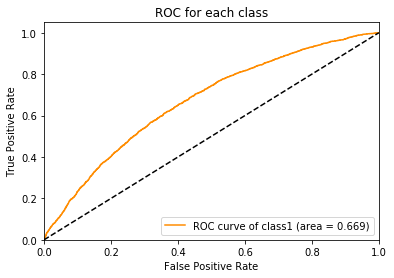

In [42]:
plot_roc(y_pred, y_true)